# Image colorizer

I built a fully convolutional network able to colorizer images using transfer learning

### What is a Fully Convolutional network

A fully convolutional neural network is a network that has no dense layers and operates fully on convolutions and has no dense layers, this is beneficial as it allows input of images of varying size

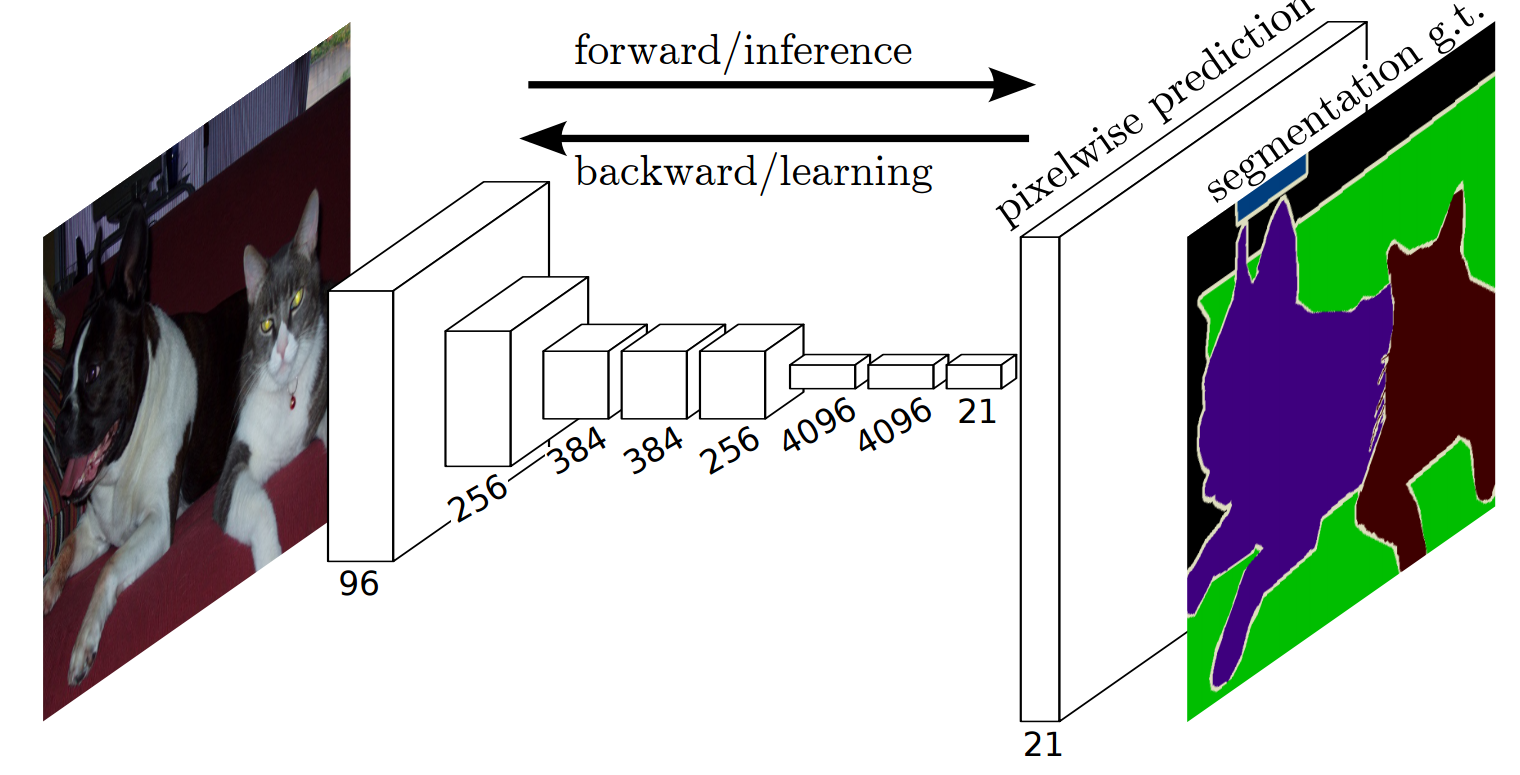

###  Examples of Fully Convolutional networks

*https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_segmentation.html
*https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef

### Training and results

The image was training took place on a dataset of 25000 grayscale and colored images, these images 224*224 and can be found in this kaggle dataset: https://www.kaggle.com/shravankumar9892/image-colorization
I first had to convert them from LAB colorspace to RGB and save them into their own directories.

The program was trained on google cloud platform and i found it didnt take long for the model to overfit, so i had to cut of training early. I figured this could be countered by adding regularizers or drop out, but neither of these seemed to benefit the model's ability to generalize much.

I figure with a more varying and larger image dataset the model be be capable of better results, it does not seem to handle very high reslution images well, but deals very well with low resolution landscape photos

### Model details

I orignally ran a U-net structure but i found this overfit even more. altough with a larger datset it could work well

The model First runs through VGG16 which was trained on the imagenet dataset. I chose this model as it was not too large and is a nice division of the input image, although the model does require three color channels so i just concatenated the gray three times.

the output of this then gets deconvoluted (Upscaled) back the the orignial size, the original input is the passed to another layer of convolutions along with the upscaled data.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, pathlib
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

1.13.1


In [2]:
batch_size = 8
epoch = 150
checkpoint_path = "cp.ckpt"

In [3]:
def load_and_preprocess_color(path):
  image = tf.read_file(path)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_gray(path):
  image = tf.read_file(path)
  image = tf.image.decode_png(image, channels=1)
  image = tf.image.resize(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range
  return image

In [4]:
input_data_root = pathlib.Path('Images/Gray/')
output_data_root = pathlib.Path('Images/Color/')

input_image_paths = [str(item) for item in input_data_root.iterdir()]
output_image_paths = [str(item) for item in output_data_root.iterdir()]
image_count = len(output_image_paths)

input_path_ds = tf.data.Dataset.from_tensor_slices(input_image_paths)
output_path_ds = tf.data.Dataset.from_tensor_slices(output_image_paths)

output_ds = output_path_ds.map(load_and_preprocess_color, num_parallel_calls=AUTOTUNE)
input_ds = input_path_ds.map(load_and_preprocess_gray, num_parallel_calls=AUTOTUNE)

input_output_ds = tf.data.Dataset.zip((input_ds, output_ds))
ds = input_output_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(batch_size)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 224, 224, 1), (?, 224, 224, 3)), types: (tf.float32, tf.float32)>

In [5]:
def Colorizer(input_height=224, input_width=224):
    vgg = tf.keras.applications.VGG16(weights='imagenet', input_tensor=None,include_top=False)
    vgg.trainable = False

    #Size of input to network must be a multiple of 32 as the network runs through 5 convolutions
    #Which reduces the size of the internal images to 2^5 = 32
    assert input_height%32 == 0
    assert input_width%32 == 0
    
    a = Input(shape=(input_height, input_width, 1))


    b = concatenate([a,a,a])
    c = vgg(b)


    d = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(c)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    d = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    d = Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    d = Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    d = Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(d)

    e = concatenate([d,a])

    f = Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False)(e)
    f = BatchNormalization()(f)
    f = LeakyReLU()(f)

    f = Conv2DTranspose(32,(5, 5), strides=(1, 1), padding='same', use_bias=False)(f)
    f = BatchNormalization()(f)
    f = LeakyReLU()(f)

    f = Conv2DTranspose(16,(5, 5), strides=(1, 1), padding='same', use_bias=False)(f)
    f = Conv2DTranspose(3,(3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid')(f)

    model = Model(inputs = a, outputs = f)

    return model

model = Colorizer(input_height = 224, input_width= 224)
model.load_weights("model_weights.h5")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 224, 224, 3)  0           input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
vgg16 (Model)                   multiple             14714688    concatenate[0][0]                
_____________________________________

In [6]:
model.compile(optimizer = tf.keras.optimizers.Adam(epsilon = 1e-4), loss = tf.losses.mean_pairwise_squared_error, metrics=["accuracy"])

Instructions for updating:
Use tf.cast instead.


In [7]:
steps_per_epoch=(image_count/batch_size)
steps_per_epoch # As we are using tf data to shuffle and batch the data we must specify the steps per epoch

3125.0

In [8]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose= 3)

In [9]:
#model.fit(ds, epochs=epoch, steps_per_epoch=3125, callbacks = [cp_callback])

In [10]:
model.save_weights('model_weights.h5')

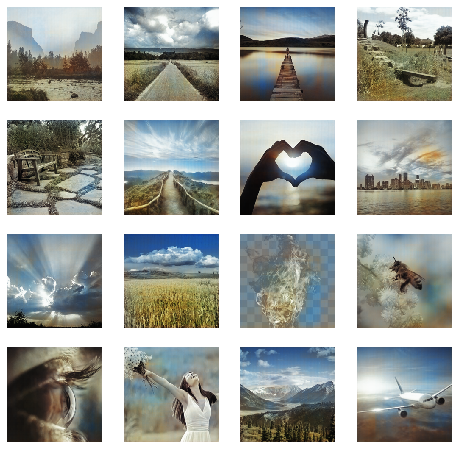

In [11]:
fig = plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = plt.imread('Images/'+str(i)+'.png')
    img = img[:,:,0]#Get one color channel as technically the images are RGB even though they appear grayscale
    out = model.predict(np.expand_dims(np.expand_dims(img, axis=-1), axis=0))[0]
    plt.imshow(out)
    plt.axis('off')